# ***NETFLIX CASE STUDY***

## **Import Libraries and load data**

In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Before Data Cleanup**

In [350]:
data.shape

(8807, 12)

In [351]:
data['type'].value_counts()

Movie      6131
TV Show    2676
Name: type, dtype: int64

In [352]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [353]:
data.isnull().sum()/len(data)*100

show_id          0.000000
type             0.000000
title            0.000000
director        29.908028
cast             9.367549
country          9.435676
date_added       0.113546
release_year     0.000000
rating           0.045418
duration         0.034064
listed_in        0.000000
description      0.000000
dtype: float64

In [354]:
data.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In [355]:
data.describe(include='object').T

,count,unique,top,freq
show_id,8807,8807,s1,1
type,8807,2,Movie,6131
title,8807,8807,Dick Johnson Is Dead,1
director,6173,4528,Rajiv Chilaka,19
cast,7982,7692,David Attenborough,19
country,7976,748,United States,2818
date_added,8797,1767,"January 1, 2020",109
rating,8803,17,TV-MA,3207
duration,8804,220,1 Season,1793
listed_in,8807,514,"Dramas, International Movies",362


In [356]:
data.groupby(['type'])['show_id'].nunique()

type
Movie      6131
TV Show    2676
Name: show_id, dtype: int64

In [357]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## **Data Cleanup**

In [358]:
# Unnesting - Explode the columns with comma-separated values into separate rows
data['director'] = data['director'].str.split(', ')
data['cast'] = data['cast'].str.split(', ')
data['country'] = data['country'].str.split(', ')
data['listed_in'] = data['listed_in'].str.split(', ')
data = data.explode('director').explode('cast').explode('country').explode('listed_in')

# Adjust Inconsistencies. For few records duration data is shifted and wrongly noted under rating column
data.loc[data['rating'].str.contains('min', na=False), 'rating'] = pd.NA

# Convert duration to Float (Remove String part. Ex :- "90 min" -> "90.0", "3 Seasons" -> "3.0")
data['duration'] = data['duration'].str.extract('(\d+)').astype(float)

# Convert date_added field to datetime data type
data['date_added'] = pd.to_datetime(data['date_added'].str.strip(), format='%B %d, %Y')

# Fill NAs
data.loc[data['type'] == 'TV Show', 'duration'] = data.loc[data['type'] == 'TV Show', 'duration'].fillna(data.loc[data['type'] == 'TV Show', 'duration'].mean())
data.loc[data['type'] == 'Movie', 'duration'] = data.loc[data['type'] == 'Movie', 'duration'].fillna(data.loc[data['type'] == 'Movie', 'duration'].mean())
data['rating'].fillna(data['rating'].mode()[0], inplace=True)
data['date_added'].fillna(data['date_added'].median() , inplace=True)
data['director'] = data['director'].fillna('unknown_director')
data['cast'] = data['cast'].fillna('unknown_cast')
data['country'] = data.groupby('director')['country'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown'))
data['country'] = data['country'].replace('', 'Unknown')

#Extract month,week,day_of_week from date_added
data['month'] = data['date_added'].dt.month.astype(int)
data['week'] = data['date_added'].dt.isocalendar().week.astype(int)
data['day_of_week'] = data['date_added'].dt.dayofweek.astype(int)

## **After Data Cleanup**

In [359]:
data.shape

(201991, 15)

In [360]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201991 entries, 0 to 8806
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   show_id       201991 non-null  object        
 1   type          201991 non-null  object        
 2   title         201991 non-null  object        
 3   director      201991 non-null  object        
 4   cast          201991 non-null  object        
 5   country       201991 non-null  object        
 6   date_added    201991 non-null  datetime64[ns]
 7   release_year  201991 non-null  int64         
 8   rating        201991 non-null  object        
 9   duration      201991 non-null  float64       
 10  listed_in     201991 non-null  object        
 11  description   201991 non-null  object        
 12  month         201991 non-null  int64         
 13  week          201991 non-null  int64         
 14  day_of_week   201991 non-null  int64         
dtypes: datetime64[ns](1

In [361]:
data.isnull().sum()/len(data)*100

show_id         0.0
type            0.0
title           0.0
director        0.0
cast            0.0
country         0.0
date_added      0.0
release_year    0.0
rating          0.0
duration        0.0
listed_in       0.0
description     0.0
month           0.0
week            0.0
day_of_week     0.0
dtype: float64

In [362]:
data.describe()

,release_year,duration,month,week,day_of_week
count,201991.000000,201991.000000,201991.000000,201991.000000,201991.000000
mean,2013.452891,77.689227,6.638167,26.703903,3.103450
std,9.003933,51.488181,3.441703,15.048304,1.728122
min,1925.000000,1.000000,1.000000,1.000000,0.000000
25%,2012.000000,4.000000,4.000000,14.000000,2.000000
50%,2016.000000,95.000000,7.000000,27.000000,3.000000
75%,2019.000000,112.000000,10.000000,39.000000,4.000000
max,2021.000000,312.000000,12.000000,53.000000,6.000000


In [363]:
data.describe(include='object').T

,count,unique,top,freq
show_id,201991,8807,s7165,700
type,201991,2,Movie,145843
title,201991,8807,Kahlil Gibran's The Prophet,700
director,201991,4994,unknown_director,50643
cast,201991,36440,unknown_cast,2146
country,201991,127,United States,64632
rating,201991,14,TV-MA,73937
listed_in,201991,42,Dramas,29775
description,201991,8775,A troubled young girl and her mother find sola...,700


In [364]:
data.groupby(['type'])['show_id'].nunique()

type
Movie      6131
TV Show    2676
Name: show_id, dtype: int64

In [365]:
data.groupby(['listed_in'])['show_id'].nunique().sort_values(ascending=False)

listed_in
International Movies            2752
Dramas                          2427
Comedies                        1674
International TV Shows          1351
Documentaries                    869
Action & Adventure               859
TV Dramas                        763
Independent Movies               756
Children & Family Movies         641
Romantic Movies                  616
TV Comedies                      581
Thrillers                        577
Crime TV Shows                   470
Kids' TV                         451
Docuseries                       395
Music & Musicals                 375
Romantic TV Shows                370
Horror Movies                    357
Stand-Up Comedy                  343
Reality TV                       255
British TV Shows                 253
Sci-Fi & Fantasy                 243
Sports Movies                    219
Anime Series                     176
Spanish-Language TV Shows        174
TV Action & Adventure            168
Korean TV Shows             

In [366]:
data.groupby(['country'])['show_id'].nunique().sort_values(ascending=False)

country
United States     4132
India             1116
United Kingdom     809
Canada             448
France             396
                  ... 
Somalia              1
Nicaragua            1
Ethiopia             1
Ecuador              1
Afghanistan          1
Name: show_id, Length: 127, dtype: int64

In [367]:
data.groupby(['rating'])['show_id'].nunique().sort_values(ascending=False)

rating
TV-MA       3214
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
Name: show_id, dtype: int64

In [368]:
data.groupby(['release_year'])['show_id'].nunique().sort_values(ascending=False)

release_year
2018    1147
2017    1032
2019    1030
2020     953
2016     902
        ... 
1959       1
1961       1
1947       1
1966       1
1925       1
Name: show_id, Length: 74, dtype: int64

In [369]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month,week,day_of_week
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,unknown_cast,United States,2021-09-25,2020,PG-13,90.0,Documentaries,"As her father nears the end of his life, filmm...",9,38,5
1,s2,TV Show,Blood & Water,unknown_director,Ama Qamata,South Africa,2021-09-24,2021,TV-MA,2.0,International TV Shows,"After crossing paths at a party, a Cape Town t...",9,38,4
1,s2,TV Show,Blood & Water,unknown_director,Ama Qamata,South Africa,2021-09-24,2021,TV-MA,2.0,TV Dramas,"After crossing paths at a party, a Cape Town t...",9,38,4
1,s2,TV Show,Blood & Water,unknown_director,Ama Qamata,South Africa,2021-09-24,2021,TV-MA,2.0,TV Mysteries,"After crossing paths at a party, a Cape Town t...",9,38,4
1,s2,TV Show,Blood & Water,unknown_director,Khosi Ngema,South Africa,2021-09-24,2021,TV-MA,2.0,International TV Shows,"After crossing paths at a party, a Cape Town t...",9,38,4


<ipython-input-370-ceaf52d99663>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


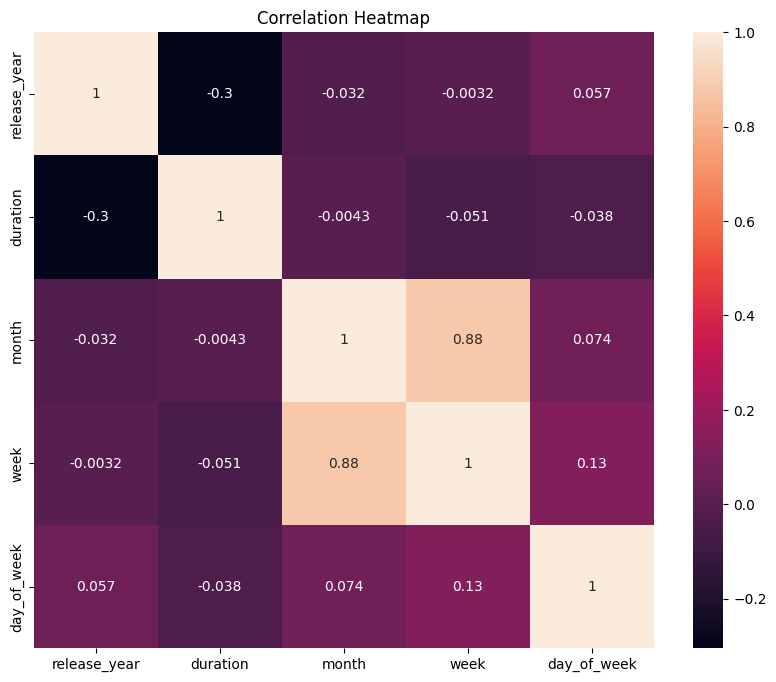

In [370]:
# Calculate correlation matrix
correlation_matrix = data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()


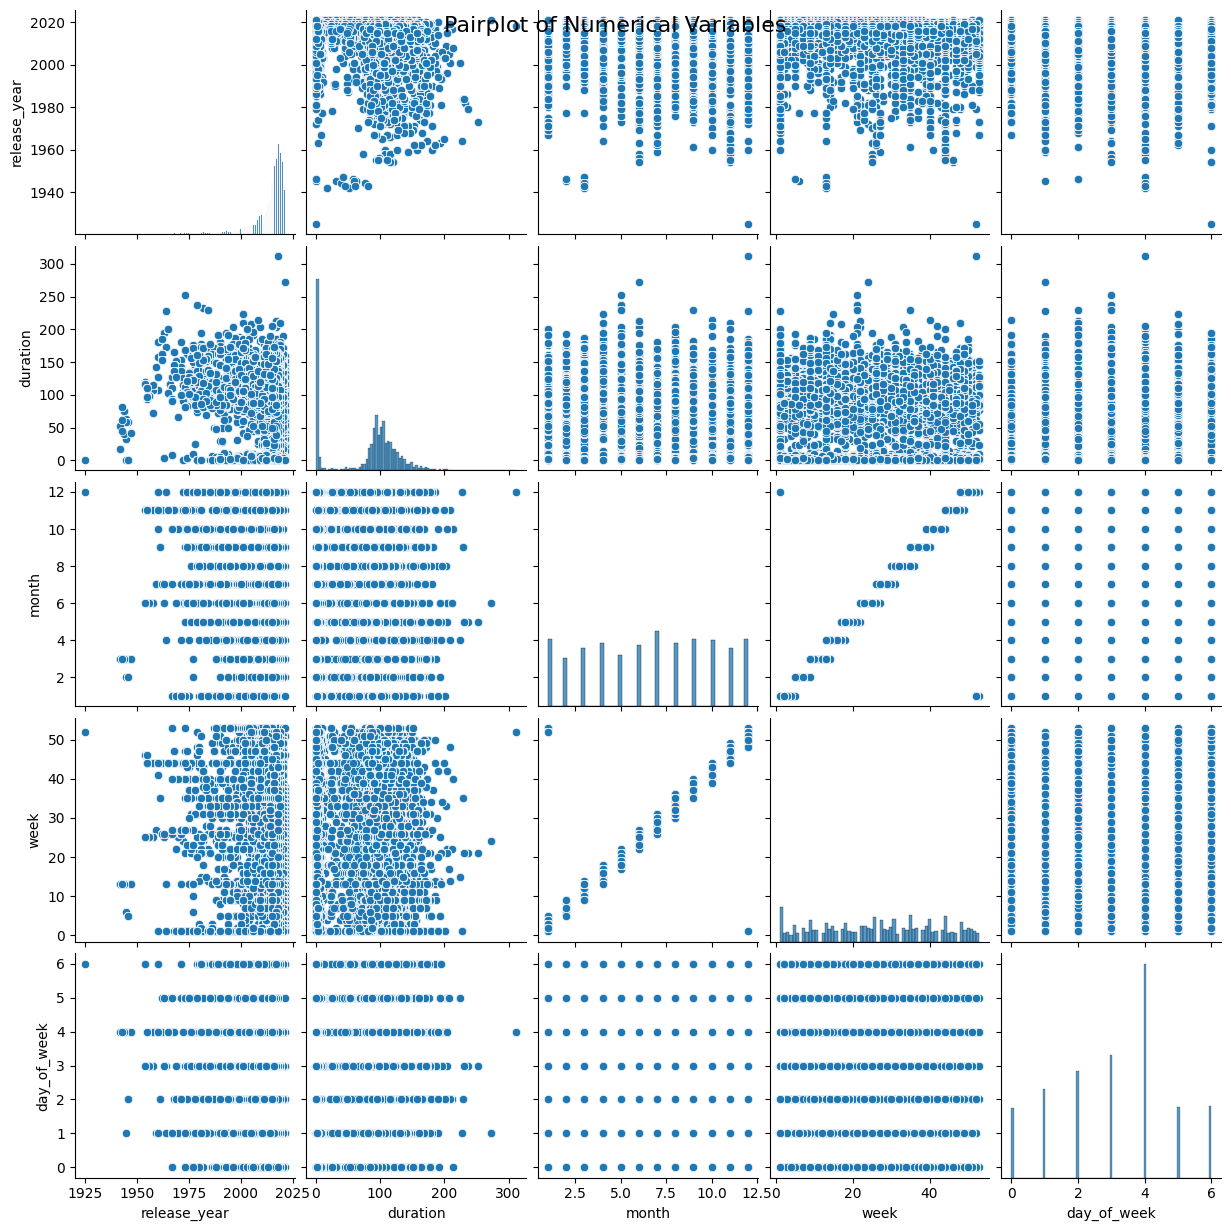

In [371]:
# Select numerical columns for the pairplot
numerical_cols = data.select_dtypes(include=['float64', 'int64'])

# Plotting the pairplot
sns.pairplot(numerical_cols)
plt.suptitle('Pairplot of Numerical Variables', fontsize=16)
plt.show()


##**1. How has the number of movies released per year changed over the last 20-30 years?**

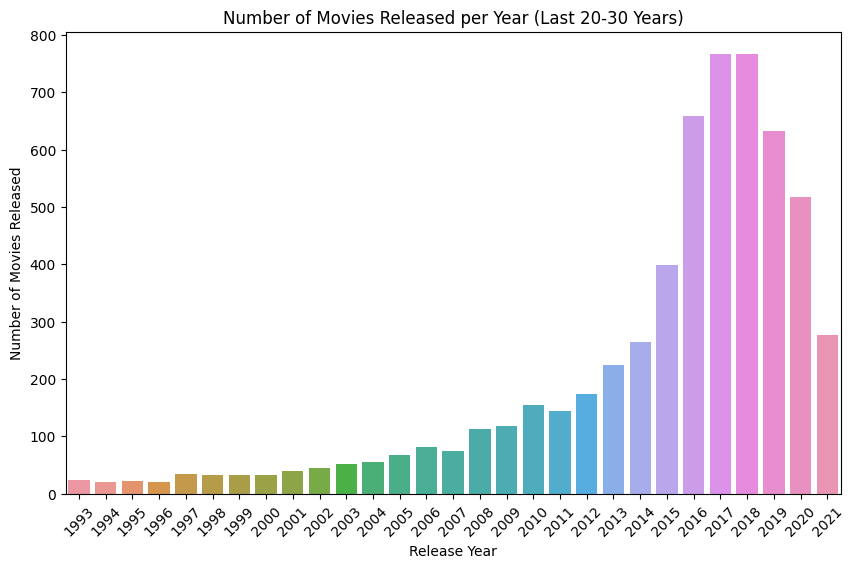

In [372]:
movies_count_20_30_years = data.loc[(data['type'] == 'Movie') & (data['release_year'].isin(range(1993,2024)))].drop_duplicates(subset='show_id').groupby('release_year')['show_id'].nunique()

plt.figure(figsize=(10, 6))
sns.barplot(x=movies_count_20_30_years.index, y=movies_count_20_30_years.values)
plt.xlabel('Release Year')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released per Year (Last 20-30 Years)')
plt.xticks(rotation=45)
plt.show()

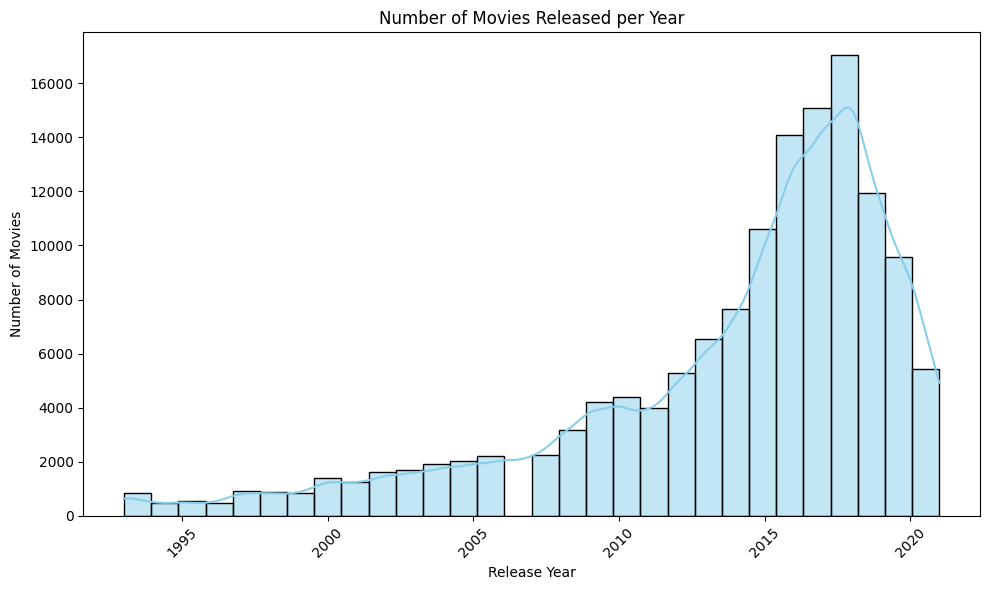

In [373]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data.loc[(data['type'] == 'Movie') & (data['release_year'].isin(range(1993,2024)))], x='release_year', bins=30, kde=True, color='skyblue')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Insights :-


*   The number of movies released per year increased exponentially over the time period from 1993 to 2018
*   There was a sudden drop in the number of movies released per year from 2019 to 2021 which might be due to Covid-19



## **2. Comparison of tv shows vs. movies.**

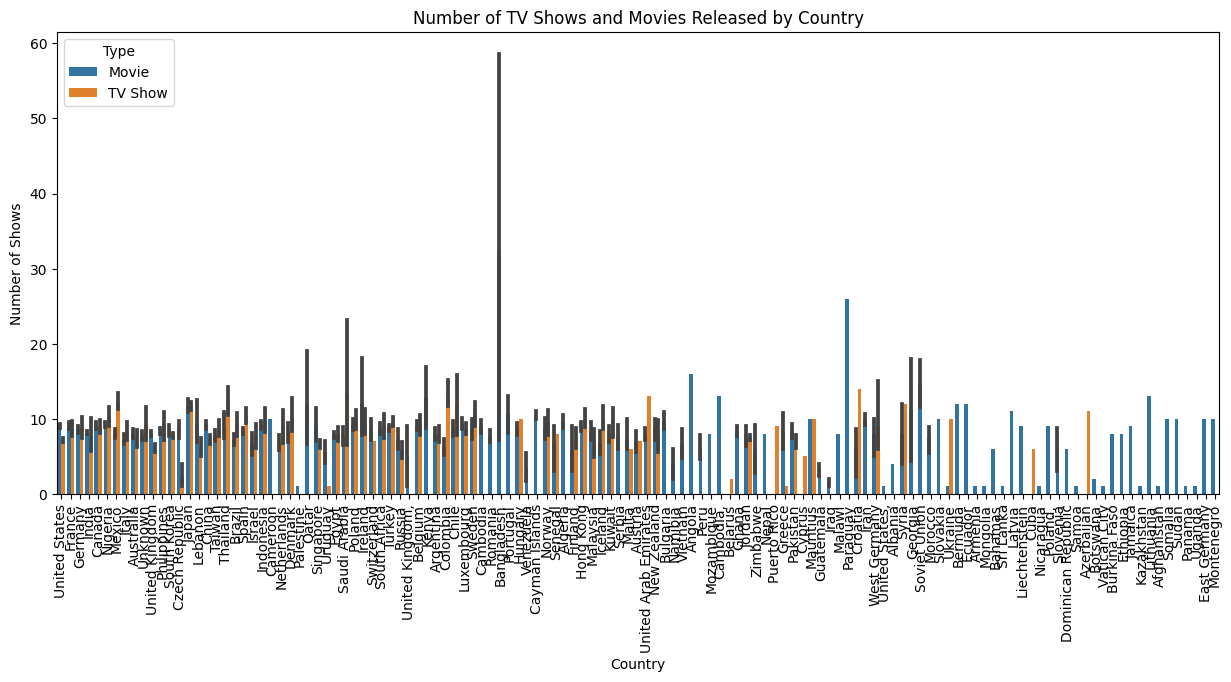

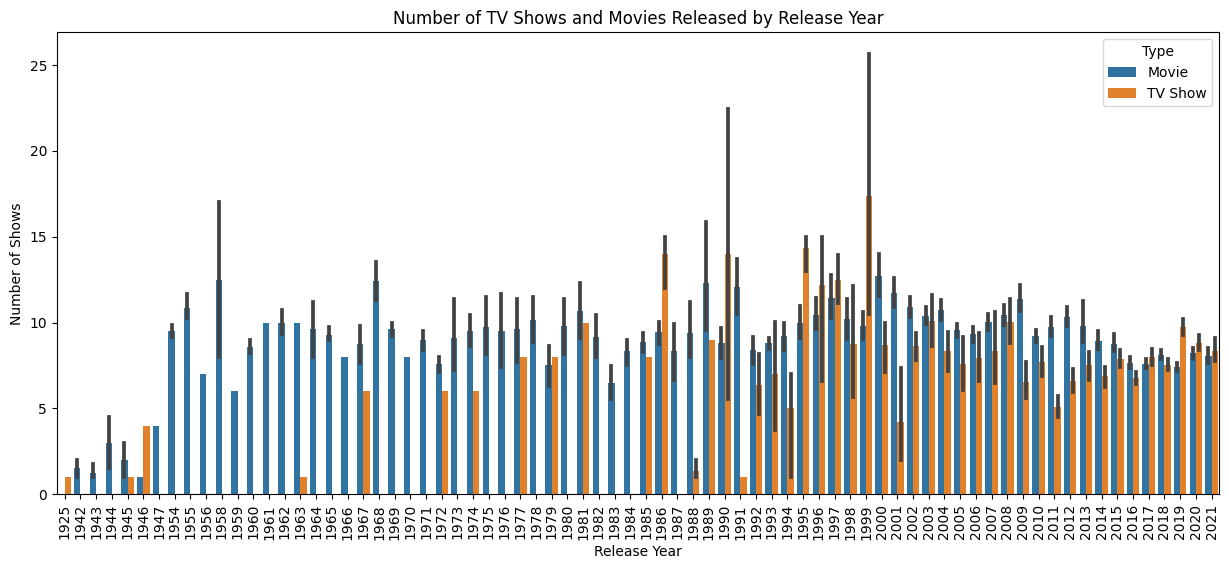

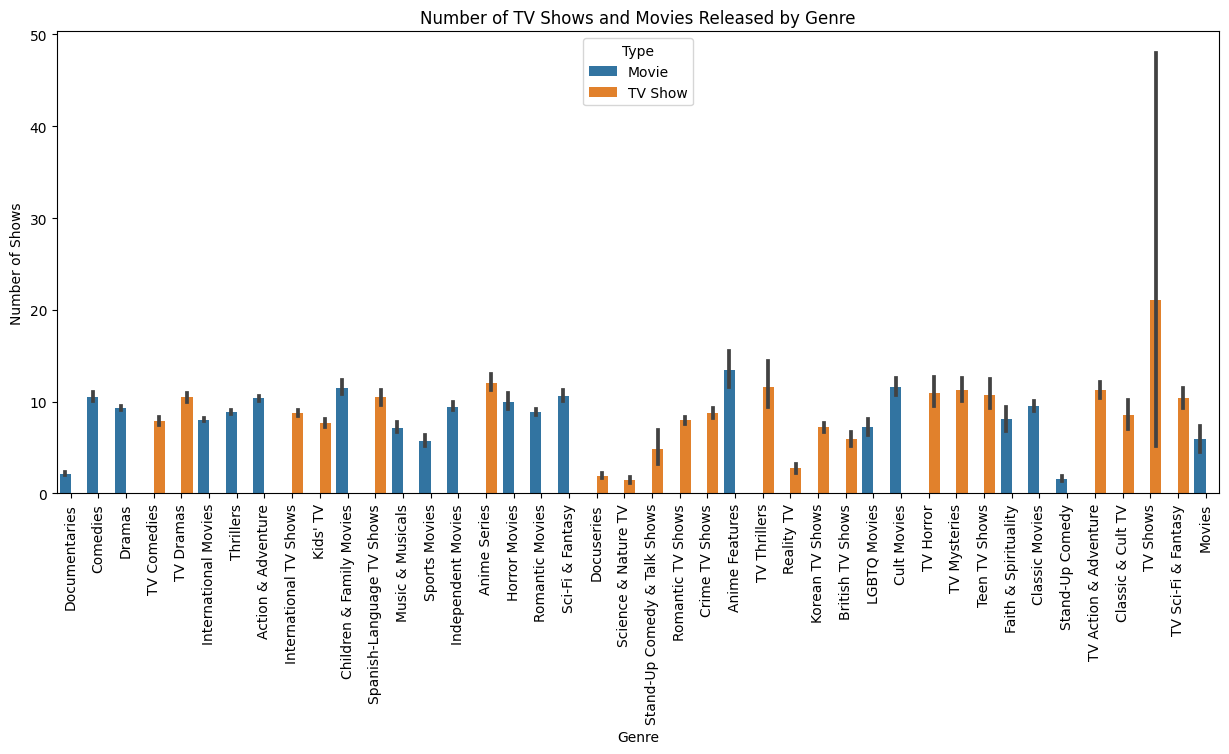

In [374]:
# Group data by 'show_id', 'type', 'country', 'release_year', and 'listed_in' and count the number of shows
grouped_data = data.groupby(['show_id', 'type', 'country', 'release_year', 'listed_in']).size().reset_index(name='count')

# Plotting by Country
plt.figure(figsize=(15, 6))
sns.barplot(x='country', y='count', hue='type', data=grouped_data)
plt.title('Number of TV Shows and Movies Released by Country')
plt.xlabel('Country')
plt.ylabel('Number of Shows')
plt.xticks(rotation=90)
plt.legend(title='Type')
plt.show()

# Plotting by Release Year
plt.figure(figsize=(15, 6))
sns.barplot(x='release_year', y='count', hue='type', data=grouped_data)
plt.title('Number of TV Shows and Movies Released by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Shows')
plt.xticks(rotation=90)
plt.legend(title='Type')
plt.show()

# Plotting by Genre
plt.figure(figsize=(15, 6))
sns.barplot(x='listed_in', y='count', hue='type', data=grouped_data)
plt.title('Number of TV Shows and Movies Released by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Shows')
plt.xticks(rotation=90)
plt.legend(title='Type')
plt.show()

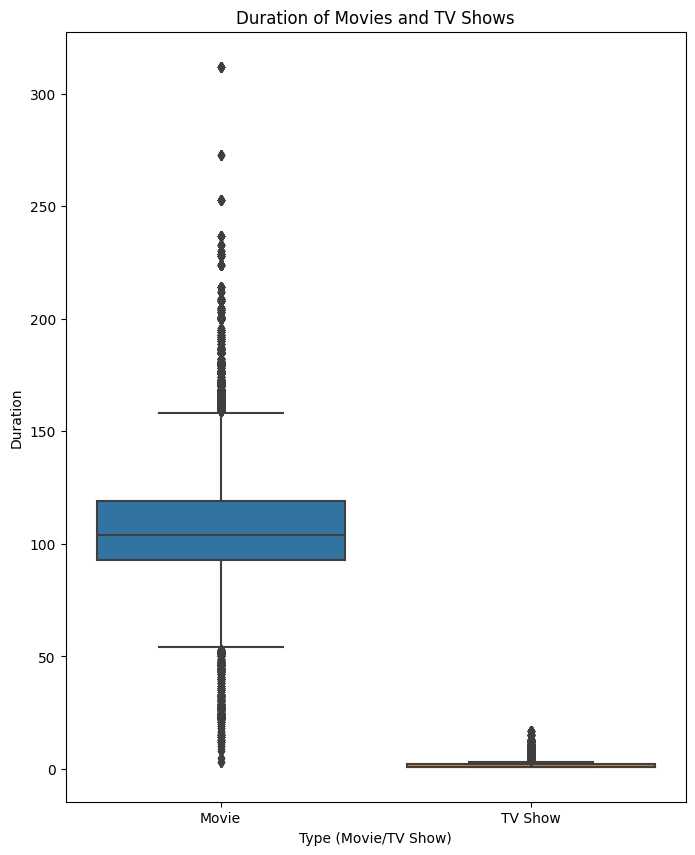

In [375]:
# Boxplot: Comparing the duration of movies and TV shows
plt.figure(figsize=(8, 10))
sns.boxplot(x='type', y='duration', data=data)
plt.xlabel('Type (Movie/TV Show)')
plt.ylabel('Duration')
plt.title('Duration of Movies and TV Shows')
plt.show()

([<matplotlib.patches.Wedge at 0x7a5e5ce45750>,
 [Text(-0.6357552620136555, 0.897672126570692, 'Movie'),
  Text(0.6357552620136554, -0.8976721265706921, 'TV Show')],
 [Text(-0.3467755974619939, 0.4896393417658319, '70%'),
  Text(0.3467755974619938, -0.48963934176583196, '30%')])

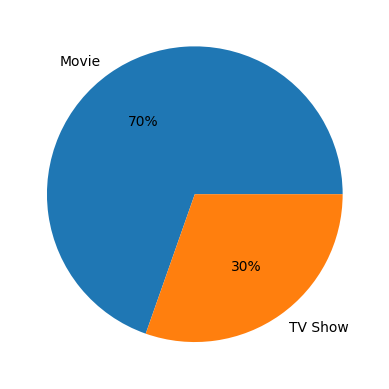

In [376]:
type_count=data.drop_duplicates(subset='show_id').groupby('type')['show_id'].nunique()
plt.pie(type_count.values,labels=type_count.index, autopct='%.0f%%')

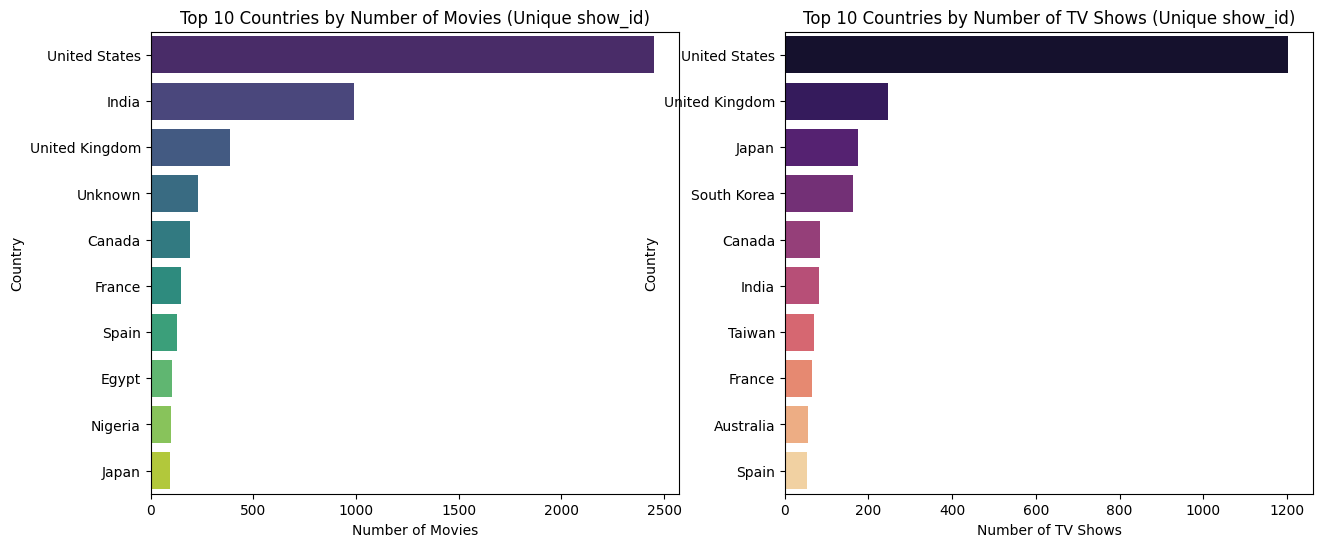

In [377]:
# a. Number of movies produced in each country (Top 10)
movies_by_country = data[data['type'] == 'Movie'].drop_duplicates(subset='show_id').groupby('country')['show_id'].count().reset_index()
top_10_movies_countries = movies_by_country.sort_values(by='show_id', ascending=False).head(10)

# b. Number of TV-Shows produced in each country (Top 10)
tv_shows_by_country = data[data['type'] == 'TV Show'].drop_duplicates(subset='show_id').groupby('country')['show_id'].count().reset_index()
top_10_tv_shows_countries = tv_shows_by_country.sort_values(by='show_id', ascending=False).head(10)

# Plotting
plt.figure(figsize=(15, 6))

# Plotting a.
plt.subplot(1, 2, 1)
sns.barplot(x='show_id', y='country', data=top_10_movies_countries, palette='viridis')
plt.title('Top 10 Countries by Number of Movies (Unique show_id)')
plt.xlabel('Number of Movies')
plt.ylabel('Country')

# Plotting b.
plt.subplot(1, 2, 2)
sns.barplot(x='show_id', y='country', data=top_10_tv_shows_countries, palette='magma')
plt.title('Top 10 Countries by Number of TV Shows (Unique show_id)')
plt.xlabel('Number of TV Shows')
plt.ylabel('Country')

plt.show()


### Insights :-


*   In the overall Dataset, there are 70% of movies and only 30% are TV Shows
*   Among all the countries United States has produced more number of Movies and TV Shows
*   After United States, India produced more number of movies, while United Kingdom produced more number of TV Shows. The top 10 Countries wrt TV Shows and Movies are shown above
*   Seeing the bar chart of Number of TV Shows and Movies released per year above, we can say that before 1990 the TV Shows shows are produced very less compared with later 1990








## **3. What is the best time to launch a TV show?**

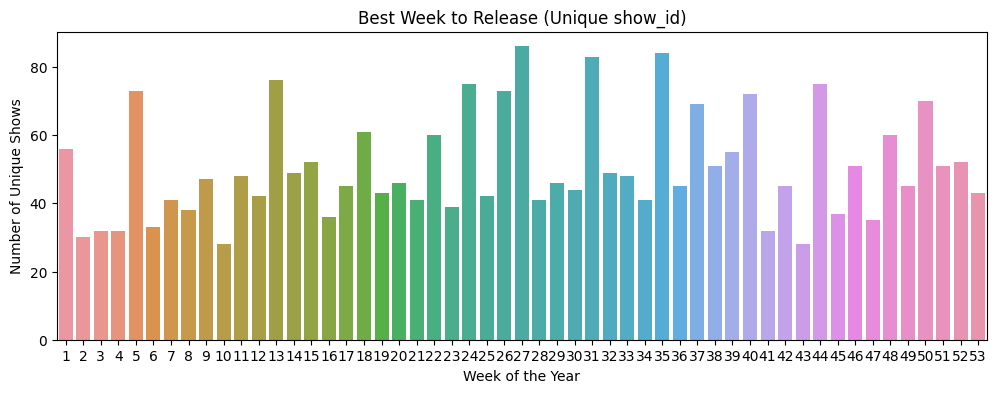

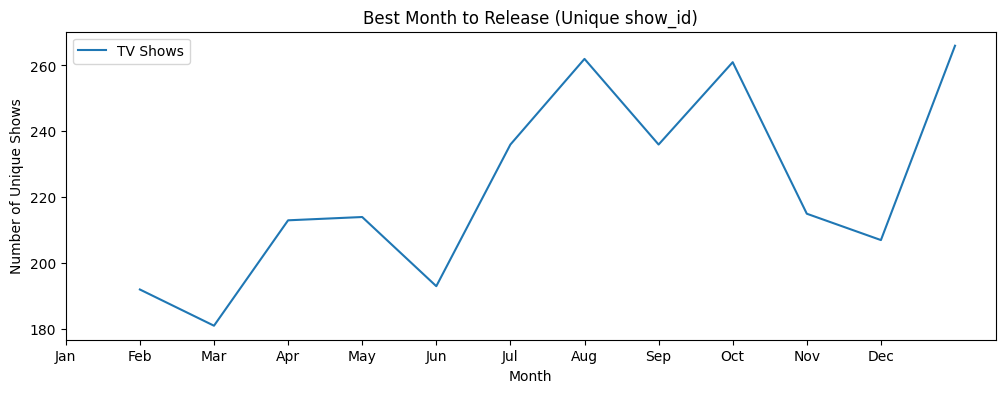

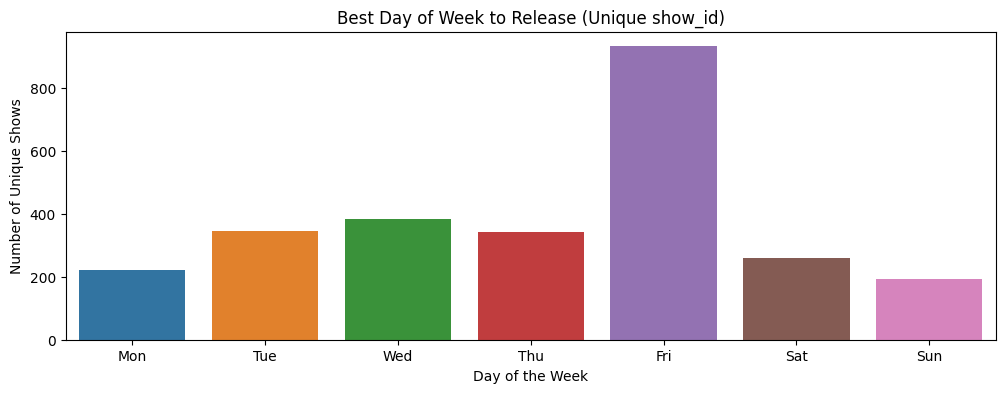

In [378]:
# Group by week for TV shows
tv_shows_by_week = data[data['type'] == 'TV Show'].drop_duplicates(subset='show_id').groupby('week')['show_id'].nunique()

# Group by month for TV shows
tv_shows_by_month = data[data['type'] == 'TV Show'].drop_duplicates(subset='show_id').groupby('month')['show_id'].nunique()

# Group by day of week for TV shows
tv_shows_by_day_of_week = data[data['type'] == 'TV Show'].drop_duplicates(subset='show_id').groupby('day_of_week')['show_id'].nunique()

# Plotting
plt.figure(figsize=(12, 4))
sns.barplot(x=tv_shows_by_week.index, y=tv_shows_by_week.values, label='TV Shows')
plt.title('Best Week to Release (Unique show_id)')
plt.xlabel('Week of the Year')
plt.ylabel('Number of Unique Shows')

plt.figure(figsize=(12, 4))
sns.lineplot(x=tv_shows_by_month.index, y=tv_shows_by_month.values, label='TV Shows')
plt.title('Best Month to Release (Unique show_id)')
plt.xlabel('Month')
plt.ylabel('Number of Unique Shows')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.figure(figsize=(12, 4))
sns.barplot(x=tv_shows_by_day_of_week.index, y=tv_shows_by_day_of_week.values, label='TV Shows')
plt.title('Best Day of Week to Release (Unique show_id)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Unique Shows')
plt.xticks(ticks=range(0, 7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.show()


### Insights :-


*   Seeing the above data, we can say that Friday is the best day of the week to release a TV Show as most releases are happened on Friday
*   The first quarter of the year doesn't seems like a good time to release a TV Show as most releases are happened during June-Sep and December end, which might be beacuse of Christmas eve





## **4. Analysis of actors/directors of different types of shows/movies.**

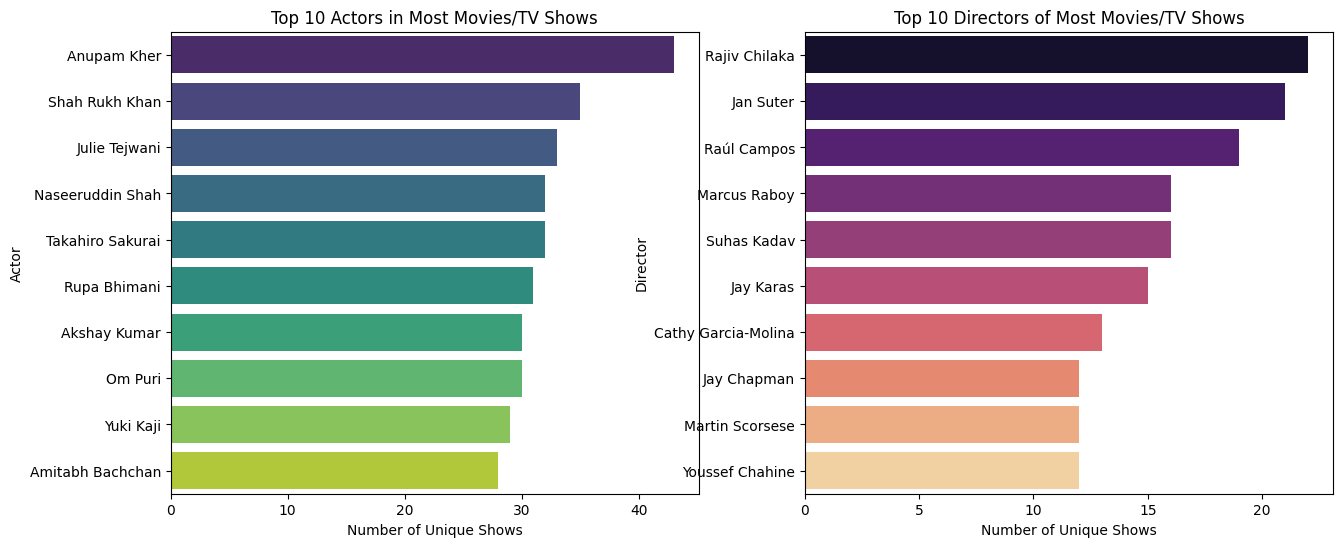

In [379]:
# a. Identify top 10 actors who have appeared in most movies or TV shows
top_actors = data.loc[data['cast']!='unknown_cast'].drop_duplicates(subset=['show_id', 'cast']).groupby('cast')['show_id'].nunique().nlargest(10)

# b. Identify top 10 directors who have directed most movies or TV shows
top_directors = data.loc[data['director']!='unknown_director'].drop_duplicates(subset=['show_id', 'director']).groupby('director')['show_id'].nunique().nlargest(10)

# Plotting
plt.figure(figsize=(15, 6))

# Plotting a.
plt.subplot(1, 2, 1)
sns.barplot(x=top_actors.values, y=top_actors.index, palette='viridis')
plt.title('Top 10 Actors in Most Movies/TV Shows')
plt.xlabel('Number of Unique Shows')
plt.ylabel('Actor')

# Plotting b.
plt.subplot(1, 2, 2)
sns.barplot(x=top_directors.values, y=top_directors.index, palette='magma')
plt.title('Top 10 Directors of Most Movies/TV Shows')
plt.xlabel('Number of Unique Shows')
plt.ylabel('Director')

plt.show()

### Insights :-


*   From the above plots, Anupam Kher and SRK seems the top 2 actors with most number of shows acted
*   From the above plots, Rajiv Chilaka and Jan Suter seems the top 2 directors with most number of shows directed
*   Top 10 Actors and Directors from the dataset are plotted above





## **5. Does Netflix has more focus on TV Shows than movies in recent years**

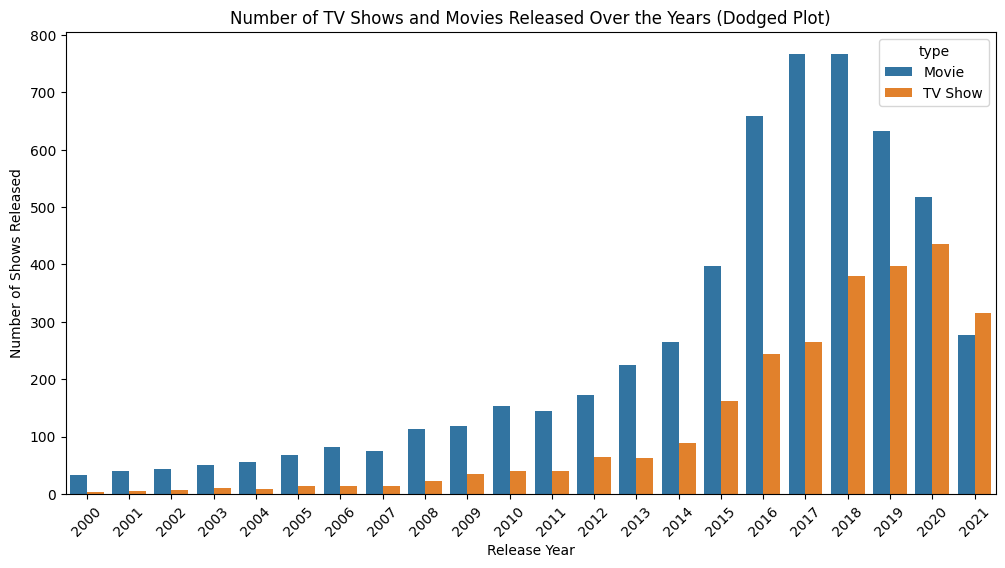

In [380]:
# Group by 'show_id' and 'release_year', count the number of TV shows and movies released each year from 2000 (recent years)
shows_by_year = data.loc[data['release_year']>=2000].groupby(['show_id', 'release_year', 'type']).size().reset_index(name='count')

# Plotting the dodged bar plot
plt.figure(figsize=(12, 6))
sns.countplot(data=shows_by_year, x='release_year', hue='type', dodge=True)
plt.xlabel('Release Year')
plt.ylabel('Number of Shows Released')
plt.title('Number of TV Shows and Movies Released Over the Years (Dodged Plot)')
plt.xticks(rotation=45)
plt.show()

### Insights :-


*   Till the year 2020, the number of Movies produced are higher than the number of TV Shows. Also the rate of production/release of TV Shows gradually increased over the years from 2000 to 2021
*   In the year 2021, the number of TV Shows produced surpassed the no. of Movies made.
*   Since the data is limited till 2021, we cannot surely tell whether Netflix has focussed more on TV Shows than movies. But surely, we can tell the the content has been exponentially increased over the years





## **6. Understanding what content is available in different countries**

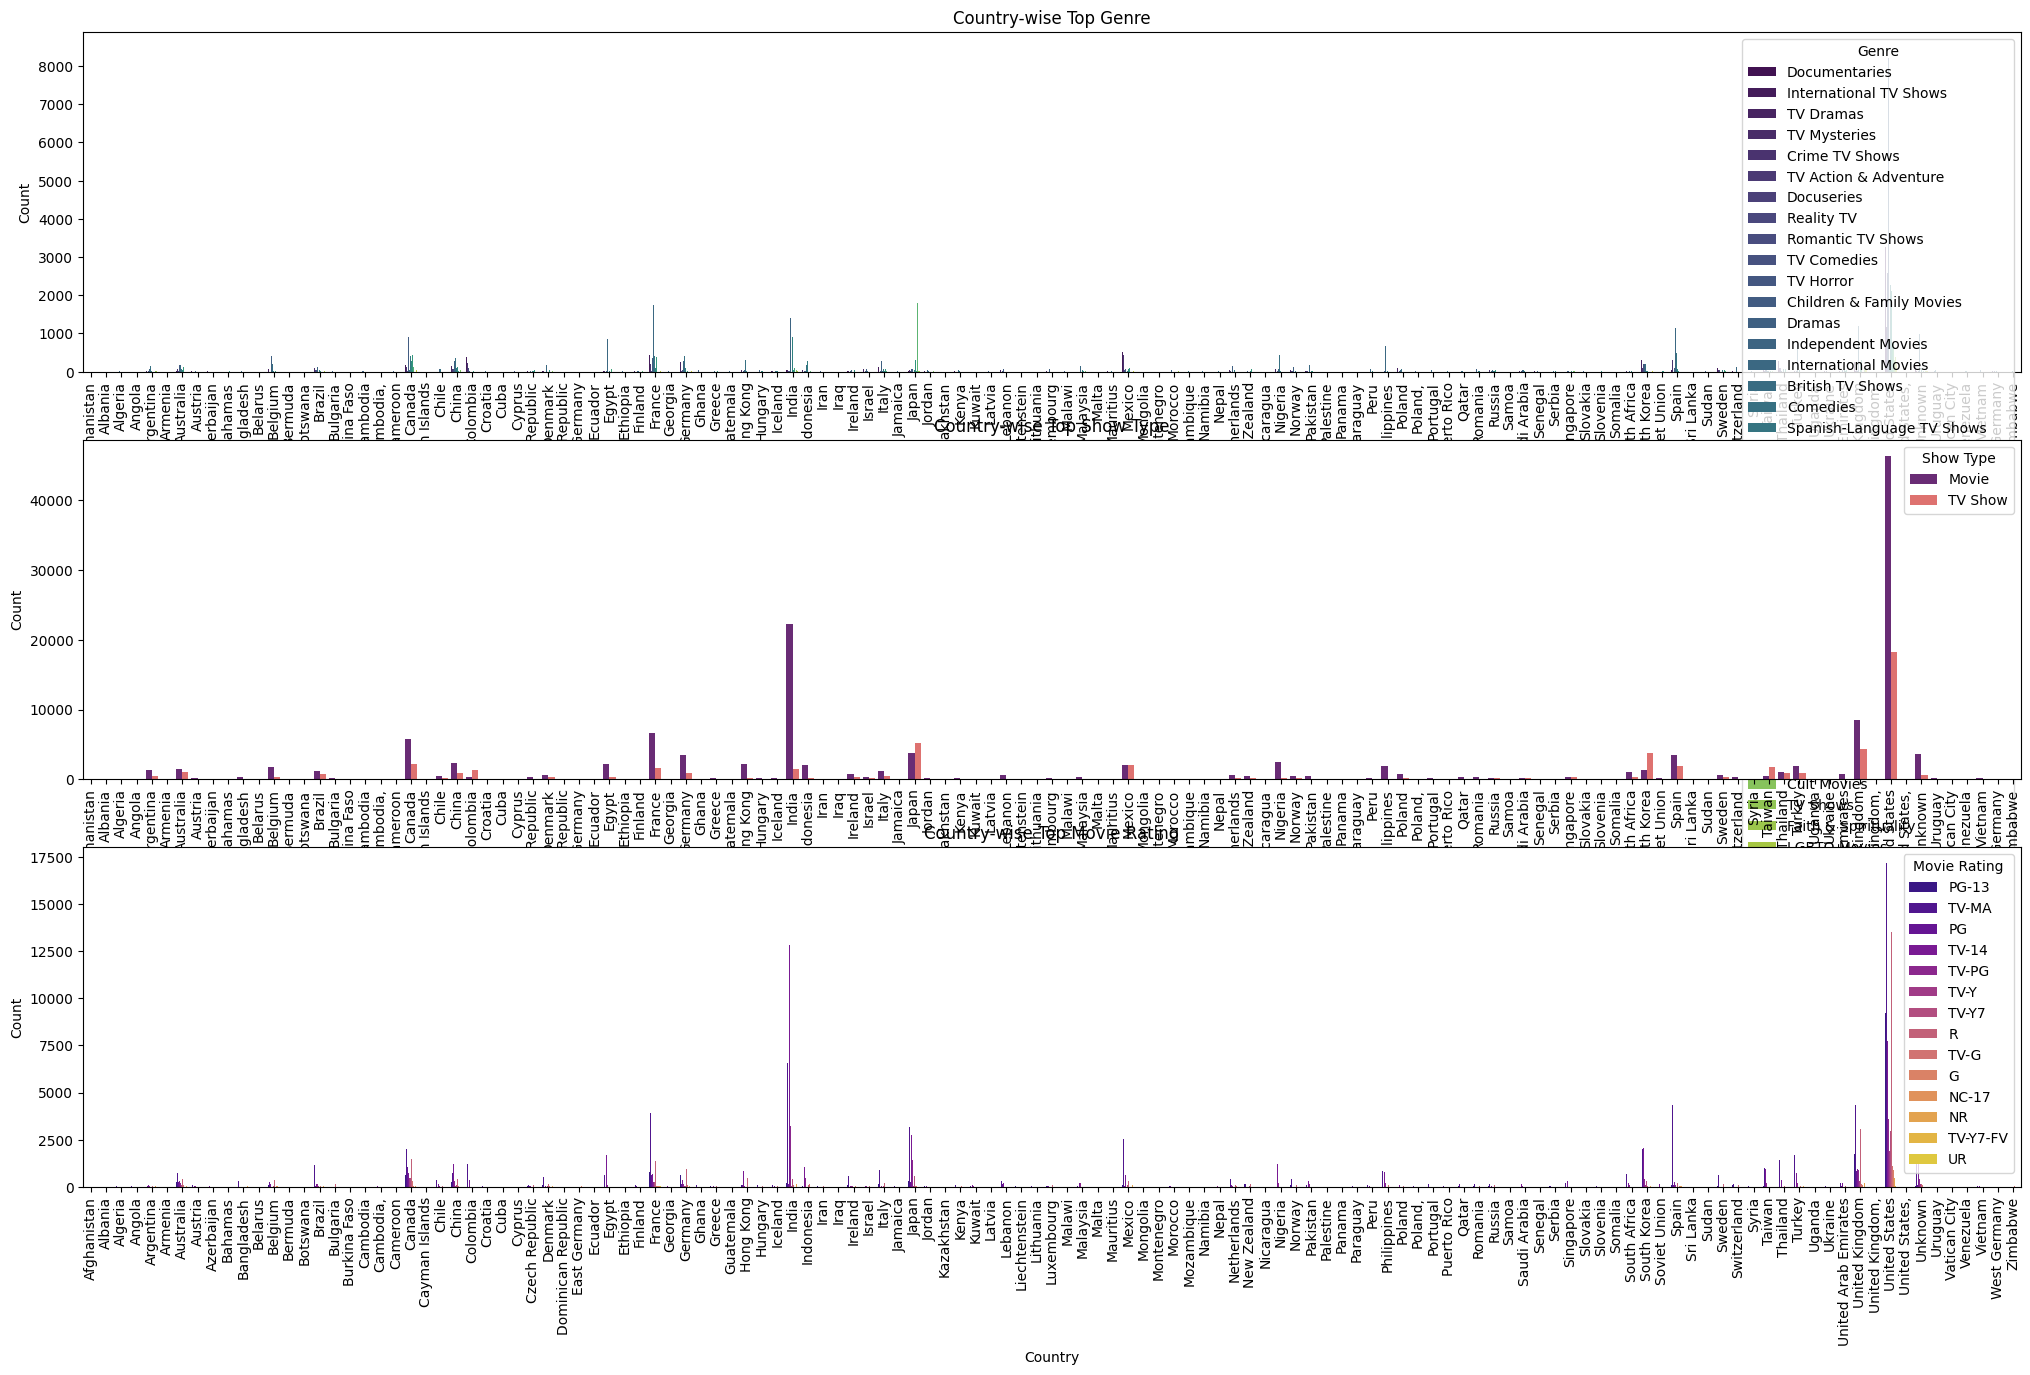

In [381]:
# Country-wise top genre (Top 1 genre for each country)
top_genre_by_country = data.drop_duplicates(subset=['show_id', 'country', 'listed_in']).groupby('country')['listed_in'].apply(lambda x: x.value_counts().idxmax())

# Country-wise top show type (TV Show/Movie)
top_show_type_by_country = data.drop_duplicates(subset=['show_id', 'country', 'type']).groupby('country')['type'].apply(lambda x: x.value_counts().idxmax())

# Country-wise top movie rating
top_rating_by_country = data.drop_duplicates(subset=['show_id', 'country', 'rating']).groupby('country')['rating'].apply(lambda x: x.value_counts().idxmax())

# Plotting
plt.figure(figsize=(25, 15))

# Plotting 1: Country-wise top genre
plt.subplot(3, 1, 1)
sns.countplot(data=data, x='country', hue='listed_in', order=top_genre_by_country.index, palette='viridis')
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Country-wise Top Genre')
plt.legend(title='Genre', loc='upper right')
plt.xticks(rotation=90)

# Plotting 2: Country-wise top show type
plt.subplot(3, 1, 2)
sns.countplot(data=data, x='country', hue='type', order=top_show_type_by_country.index, palette='magma')
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Country-wise Top Show Type')
plt.legend(title='Show Type', loc='upper right')
plt.xticks(rotation=90)

# Plotting 3: Country-wise top movie rating
plt.subplot(3, 1, 3)
sns.countplot(data=data, x='country', hue='rating', order=top_rating_by_country.index, palette='plasma')
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Country-wise Top Movie Rating')
plt.legend(title='Movie Rating', loc='upper right')
plt.xticks(rotation=90)

plt.show()

In [382]:
pd.DataFrame({"country": top_genre_by_country.index,"top_genre": top_genre_by_country.values})

,country,top_genre
0,Afghanistan,Documentaries
1,Albania,Dramas
2,Algeria,Dramas
3,Angola,Action & Adventure
4,Argentina,International Movies
...,...,...
122,Vatican City,Documentaries
123,Venezuela,International Movies
124,Vietnam,International Movies
125,West Germany,International Movies


In [383]:
pd.DataFrame({"country": top_show_type_by_country.index,"top_show_type": top_show_type_by_country.values})

,country,top_show_type
0,Afghanistan,Movie
1,Albania,Movie
2,Algeria,Movie
3,Angola,Movie
4,Argentina,Movie
...,...,...
122,Vatican City,Movie
123,Venezuela,Movie
124,Vietnam,Movie
125,West Germany,Movie


In [384]:
pd.DataFrame({"country": top_rating_by_country.index,"max_rating_shows": top_rating_by_country.values})

,country,max_rating_shows
0,Afghanistan,TV-MA
1,Albania,TV-MA
2,Algeria,TV-MA
3,Angola,TV-MA
4,Argentina,TV-MA
...,...,...
122,Vatican City,PG
123,Venezuela,TV-14
124,Vietnam,TV-14
125,West Germany,TV-MA


### Insights :-


*   The above data shows the best/top genre,show type,rating with respect to individual country





##**Overall Insights & Recommendations**



*   The given data is in between year 1925 and 2021
*   During Data clean, columns - country, cast, director, listed_in found to be nested and so unnested. Also found some inconsistent data where for few rows, duration values are shifted to rating column. Most of the columns which are improper data type format are converted to proper data format. Ex : date_added to date format. Duration to float etc. Empty/NA values are found in most of the columns and are replaced with proper data like Mean, Mode etc.
*   In the given data, 70% of the shows are Movies and 30% are TV Shows
*   The below mentioned are the top 5 Genres among which the shows are distributed : International Movies, Dramas, Comedies, International TV Shows, Documentaries
*   United States and India are top 2 countries to produce the most shows
*   Anupam Kher and SRK are the top 2 actors with most number of shows acted
*   Rajiv Chilaka and Jan Suter are the top 2 directors with most number of shows directed
*   106 Minutes is the mean duration of Movie Shows from the given dataset
*   2 Seasons is the mean duration of TV Shows from the given dataset
*   The year 2018 has the most number of releases
*   Most TV Shows are released on Fridays
*   Most shows are rated with rating TV-MA

*   Create diverse content in popular genres, emphasizing international shows and movies to attract a broader audience.
*   Collaborate with renowned actors and directors for exclusive, high-quality productions
*   Schedule new releases on Fridays to maximize viewership during the weekend.
*   Utilize data analysis to guide content decisions, focusing on trends, viewer preferences, and personalized recommendations









